# 三阶段自动标注 Pipeline

- **Stage 1**: 正则提取物体名称
- **Stage 2**: Grounding DINO 检测 + 序号标注
- **Stage 3**: VLM 筛选检测结果

In [ ]:
# 1. 环境设置
import os
import sys
import re
import base64
from pathlib import Path
from io import BytesIO
from collections import defaultdict
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple, Union

os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont
import torch

PROJECT_ROOT = Path('D:/files/VLA-Adapter')
print(f'项目根目录: {PROJECT_ROOT}')
print(f'CUDA 可用: {torch.cuda.is_available()}')

项目根目录: D:\files\VLA-Adapter
CUDA 可用: True


数据目录: D:\files\VLA-Adapter\data\modified_libero_rlds\libero_10_no_noops\1.0.0
语言指令: put the white mug on the left plate and put the yellow and white mug on the right plate
首帧形状: (256, 256, 3)


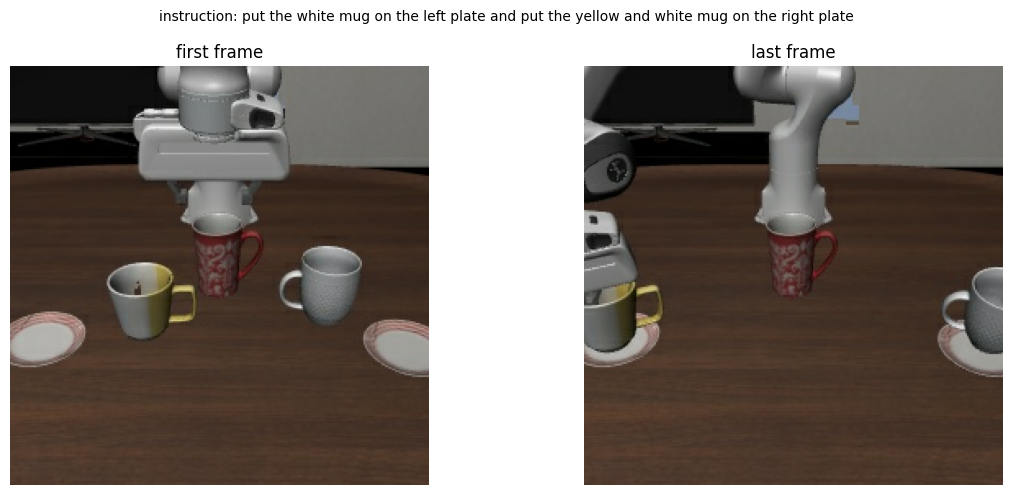

In [ ]:
# 2. 加载数据
import tensorflow_datasets as tfds

DATA_DIR = PROJECT_ROOT / 'data' / 'modified_libero_rlds' / 'libero_10_no_noops' / '1.0.0'
print(f'数据目录: {DATA_DIR}')

builder = tfds.builder_from_directory(str(DATA_DIR))
ds = builder.as_dataset(split='train')

for episode in ds.take(1):
    steps = list(episode['steps'])
    first_frame = steps[0]['observation']['image'].numpy()
    last_frame = steps[-1]['observation']['image'].numpy()
    instruction = steps[0]['language_instruction'].numpy().decode('utf-8')
    break

print(f'语言指令: {instruction}')
print(f'首帧形状: {first_frame.shape}')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(first_frame)
axes[0].set_title('first frame')
axes[0].axis('off')
axes[1].imshow(last_frame)
axes[1].set_title('last frame')
axes[1].axis('off')
plt.suptitle(f'instruction: {instruction}', fontsize=10)
plt.tight_layout()
plt.show()

## Stage 1: 正则提取物体名称

In [4]:
# Stage 1: 正则提取
ATTRIBUTE_WORDS = {'red', 'blue', 'green', 'yellow', 'white', 'black', 'orange', 'purple', 'pink', 'brown', 'gray', 'grey', 'left', 'right', 'top', 'bottom'}
ACTION_VERBS = {'close', 'open', 'turn', 'pick', 'put', 'place', 'grab', 'push', 'pull', 'move', 'lift', 'drop', 'take'}

def is_attribute_after_and(text):
    if not text: return False
    words = text.strip().split()
    if not words: return False
    first = words[0].lower()
    if first in ATTRIBUTE_WORDS: return True
    if first in ACTION_VERBS: return False
    if first in {'it', 'them', 'this', 'that'}: return False
    return True

def clean_target(s):
    if not s: return s
    cleaned = s.strip()
    match = re.search(r'\s+and\s+', cleaned, re.IGNORECASE)
    while match:
        if is_attribute_after_and(cleaned[match.end():]):
            remaining = cleaned[match.end():]
            next_match = re.search(r'\s+and\s+', remaining, re.IGNORECASE)
            if not next_match: break
            match = re.search(r'\s+and\s+', cleaned[match.end() + next_match.end():], re.IGNORECASE)
        else:
            cleaned = cleaned[:match.start()].strip()
            break
    return re.sub(r'\s+then\s+\w+.*$', '', cleaned, flags=re.IGNORECASE).strip()

def extract_source_target(instruction):
    instruction = instruction.lower().strip()
    result = {'action': None, 'source': None, 'target': None}
    instruction_clean = re.sub(r'\s+and\s+(close|open)\s+(it|the\s+\w+)\s*$', '', instruction, flags=re.IGNORECASE)
    
    patterns = [
        (r'(put|place)\s+(?:the\s+)?(.+?)\s+(on|in|into)\s+(?:the\s+)?(.+?)\s+and\s+(put|place)\s+(?:the\s+)?(.+?)\s+(on|in|into)\s+(?:the\s+)?(.+)$',
         lambda m: {'action': m.group(1), 'source': [m.group(2).strip(), m.group(6).strip()], 'target': [clean_target(m.group(4)), clean_target(m.group(8))]}),
        (r'(put|place)\s+(?:the\s+)?(.+?)\s+(on|in|into)\s+(?:the\s+)?(.+)$',
         lambda m: {'action': m.group(1), 'source': [m.group(2).strip()], 'target': [clean_target(m.group(4))]}),
        (r'(pick up|pick)\s+(?:the\s+)?(.+?)$',
         lambda m: {'action': 'pick up', 'source': [m.group(2).strip()], 'target': None}),
        (r'(open|close)\s+(?:the\s+)?(.+)$',
         lambda m: {'action': m.group(1), 'source': [clean_target(m.group(2))], 'target': None}),
    ]
    
    for pattern, extractor in patterns:
        match = re.match(pattern, instruction_clean, re.IGNORECASE)
        if match:
            extracted = extractor(match)
            result.update(extracted)
            break
    return result

def get_object_list(instruction):
    result = extract_source_target(instruction)
    objects = []
    if result['source']: objects.extend(result['source'])
    if result['target']: objects.extend(result['target'])
    return list(set(objects)) if objects else ['object']

# 测试
parsed = extract_source_target(instruction)
objects = get_object_list(instruction)
print('=' * 60)
print('Stage 1: 正则提取结果')
print('=' * 60)
print(f'指令: {instruction}')
print(f'Action: {parsed["action"]}')
print(f'Source: {parsed["source"]}')
print(f'Target: {parsed["target"]}')
print(f'待检测物体: {objects}')

Stage 1: 正则提取结果
指令: put the white mug on the left plate and put the yellow and white mug on the right plate
Action: put
Source: ['white mug', 'yellow and white mug']
Target: ['left plate', 'right plate']
待检测物体: ['white mug', 'yellow and white mug', 'right plate', 'left plate']


## Stage 2: Grounding DINO 检测

In [5]:
# 加载模型
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

MODEL_PATH = PROJECT_ROOT / 'checkpoints' / 'grounding-dino-tiny'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'模型路径: {MODEL_PATH}')
print(f'使用设备: {device}')

processor = AutoProcessor.from_pretrained(str(MODEL_PATH))
model = AutoModelForZeroShotObjectDetection.from_pretrained(str(MODEL_PATH))
model.to(device)
model.eval()
print('模型加载完成')

模型路径: D:\files\VLA-Adapter\checkpoints\grounding-dino-tiny
使用设备: cuda
模型加载完成


In [6]:
# Stage 2: 检测
@dataclass
class Detection:
    label: str
    numbered_label: str
    box: Tuple[int, int, int, int]
    score: float
    color: Tuple[int, int, int] = None
    color_name: str = ''

COLORS = [((255,0,0), '红框'), ((0,255,0), '绿框'), ((0,0,255), '蓝框'), ((255,255,0), '黄框'), ((255,0,255), '紫框'), ((0,255,255), '青框')]

def detect_objects(image, object_names, box_threshold=0.25, text_threshold=0.25):
    pil_image = Image.fromarray(image) if isinstance(image, np.ndarray) else image
    text_prompt = ' . '.join(object_names) + ' .'
    print(f'检测 Prompt: {text_prompt}')
    
    inputs = processor(images=pil_image, text=text_prompt, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    results = processor.post_process_grounded_object_detection(
        outputs, inputs['input_ids'],
        threshold=box_threshold, text_threshold=text_threshold,
        target_sizes=[pil_image.size[::-1]]
    )[0]
    
    label_groups = defaultdict(list)
    detections = []
    for box, score, label in zip(results['boxes'].cpu().numpy(), results['scores'].cpu().numpy(), results['labels']):
        det = Detection(label=label, numbered_label=label, box=tuple(map(int, box)), score=float(score))
        label_groups[label].append(det)
        detections.append(det)
    
    for label, group in label_groups.items():
        group.sort(key=lambda x: x.score, reverse=True)
        for idx, det in enumerate(group, start=1):
            if len(group) > 1:
                det.numbered_label = f'{label}_{idx}'
    
    for i, det in enumerate(detections):
        det.color, det.color_name = COLORS[i % len(COLORS)]
    
    return detections

def draw_detections(image, detections):
    pil_image = Image.fromarray(image).convert('RGB') if isinstance(image, np.ndarray) else image.convert('RGB')
    annotated = pil_image.copy()
    draw = ImageDraw.Draw(annotated)
    try:
        font = ImageFont.truetype('arial.ttf', 14)
    except:
        font = ImageFont.load_default()
    
    for det in detections:
        x1, y1, x2, y2 = det.box
        for offset in range(3):
            draw.rectangle([x1-offset, y1-offset, x2+offset, y2+offset], outline=det.color)
        label_y = max(0, y1 - 18)
        draw.rectangle([x1, label_y, x1 + len(det.numbered_label) * 8 + 4, y1], fill=det.color)
        draw.text((x1 + 2, label_y + 2), det.numbered_label, fill=(255, 255, 255), font=font)
    return annotated

print('检测函数定义完成')

检测函数定义完成


Stage 2: Grounding DINO 检测
检测 Prompt: white mug . yellow and white mug . right plate . left plate .

检测到 6 个物体:
- 红框 white mug: (632,414,843,621) [置信度: 0.70]
- 绿框 yellow mug_1: (218,453,445,656) [置信度: 0.62]
- 蓝框 right plate plate_2: (835,593,996,746) [置信度: 0.37]
- 黄框 right plate plate_1: (0,574,183,722) [置信度: 0.41]
- 紫框 yellow mug_2: (421,343,605,554) [置信度: 0.29]
- 青框 right plate: (816,566,1000,777) [置信度: 0.30]


d:\wu_work\anaconda3\envs\grounding_dino\lib\site-packages\transformers\models\grounding_dino\processing_grounding_dino.py:93: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


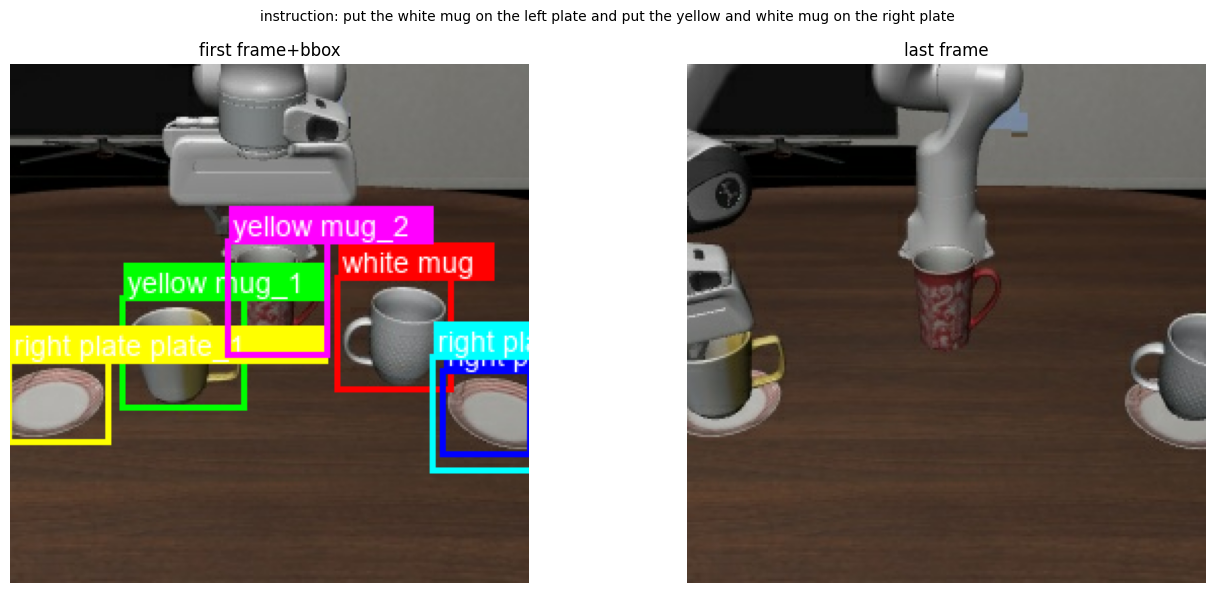

: 

In [ ]:
# 执行检测
print('=' * 60)
print('Stage 2: Grounding DINO 检测')
print('=' * 60)

detections = detect_objects(first_frame, objects)
print(f'\n检测到 {len(detections)} 个物体:')

img_h, img_w = first_frame.shape[:2]
detection_lines = []
for det in detections:
    x1, y1, x2, y2 = det.box
    norm_box = (int(x1*1000/img_w), int(y1*1000/img_h), int(x2*1000/img_w), int(y2*1000/img_h))
    line = f'- {det.color_name} {det.numbered_label}: ({norm_box[0]},{norm_box[1]},{norm_box[2]},{norm_box[3]}) [置信度: {det.score:.2f}]'
    detection_lines.append(line)
    print(line)

detection_text = '\n'.join(detection_lines)
annotated_image = draw_detections(first_frame, detections)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(annotated_image)
axes[0].set_title('first frame+bbox')
axes[0].axis('off')
axes[1].imshow(last_frame)
axes[1].set_title('last frame')
axes[1].axis('off')
plt.suptitle(f'instruction: {instruction}', fontsize=10)
plt.tight_layout()
plt.show()

## Stage 3: VLM 筛选

In [ ]:
# Stage 3: VLM 筛选函数
def encode_image(image):
    if isinstance(image, np.ndarray):
        pil_image = Image.fromarray(image)
    elif isinstance(image, Image.Image):
        pil_image = image
    else:
        pil_image = image
    buffer = BytesIO()
    pil_image.save(buffer, format='JPEG', quality=85)
    return base64.b64encode(buffer.getvalue()).decode('utf-8')

def vlm_select(first_with_boxes, last_frame_img, detection_text, instruction_text):
    api_key = os.environ.get('DASHSCOPE_API_KEY')
    if not api_key:
        print('请设置 DASHSCOPE_API_KEY')
        print('os.environ["DASHSCOPE_API_KEY"] = "your_key"')
        return None
    
    import dashscope
    from dashscope import MultiModalConversation
    dashscope.api_key = api_key
    
    prompt = f'''你正在分析一个机器人操作任务。

**任务指令**: "{instruction_text}"

**以下是在第一张图像中检测到的物体（已用彩色框标出）**：
{detection_text}

请观察这两张图片：
- **第一张**：操作开始前的场景（物体已用彩色框标注）
- **第二张**：操作完成后的场景

**请根据任务指令，对比两张图片中物体位置的变化，回答：**
1. **source**：哪个物体被机械臂移动了？（选择框的编号，如 mug_1）
2. **target**：它被放到了什么位置？（选择目标位置的框编号，如 plate）

source: [编号]
target: [编号]'''
    
    first_b64 = encode_image(first_with_boxes)
    last_b64 = encode_image(last_frame_img)
    
    print('调用 VLM API...')
    
    try:
        response = MultiModalConversation.call(
            model='qwen-vl-max',
            messages=[{
                'role': 'user',
                'content': [
                    {'image': f'data:image/jpeg;base64,{first_b64}'},
                    {'image': f'data:image/jpeg;base64,{last_b64}'},
                    {'text': prompt}
                ]
            }]
        )
        
        if response.status_code == 200:
            content = response.output.choices[0].message.content
            if isinstance(content, list):
                text_parts = [item.get('text', str(item)) if isinstance(item, dict) else str(item) for item in content]
                content = '\n'.join(text_parts)
            
            print('\n' + '=' * 40)
            print('VLM 原始响应:')
            print('=' * 40)
            print(content)
            print('=' * 40)
            
            result = {'source': None, 'target': None, 'raw': content}
            source_match = re.search(r'source\s*[:：]\s*(\S+)', content, re.IGNORECASE)
            if source_match:
                val = source_match.group(1).strip().strip('[]"\'')
                if val.lower() not in ['无', 'none', 'null', '']:
                    result['source'] = val
            target_match = re.search(r'target\s*[:：]\s*(\S+)', content, re.IGNORECASE)
            if target_match:
                val = target_match.group(1).strip().strip('[]"\'')
                if val.lower() not in ['无', 'none', 'null', '']:
                    result['target'] = val
            return result
        else:
            print(f'API 错误: {response.code}')
            return None
    except Exception as e:
        print(f'调用失败: {e}')
        import traceback
        traceback.print_exc()
        return None

print('VLM 筛选函数定义完成')

In [ ]:
# 设置 API Key（取消注释并填入你的 key）
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here'

print('=' * 60)
print('Stage 3: VLM 筛选')
print('=' * 60)
print(f'\n发送给 VLM 的检测结果:')
print(detection_text)

vlm_result = vlm_select(annotated_image, last_frame, detection_text, instruction)

if vlm_result:
    print('\n' + '=' * 60)
    print('解析结果:')
    print('=' * 60)
    print(f'Source: {vlm_result["source"]}')
    print(f'Target: {vlm_result["target"]}')
    
    source_box = target_box = None
    for det in detections:
        if vlm_result['source'] and det.numbered_label == vlm_result['source']:
            source_box = det.box
        if vlm_result['target'] and det.numbered_label == vlm_result['target']:
            target_box = det.box
    print(f'Source BBox: {source_box}')
    print(f'Target BBox: {target_box}')

In [ ]:
# 可视化最终结果
def visualize_final_result(first_img, last_img, instr, dets, vlm_res):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].imshow(first_img)
    axes[0].set_title('首帧 + 标注')
    axes[0].axis('off')
    
    for det in dets:
        x1, y1, x2, y2 = det.box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='gray', facecolor='none', linestyle='--')
        axes[0].add_patch(rect)
        axes[0].text(x1, y1 - 2, det.numbered_label, color='gray', fontsize=8)
    
    if vlm_res and vlm_res.get('source'):
        for det in dets:
            if det.numbered_label == vlm_res['source']:
                x1, y1, x2, y2 = det.box
                rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=3, edgecolor='lime', facecolor='none')
                axes[0].add_patch(rect)
                axes[0].text(x1, y1 - 5, f'Source: {vlm_res["source"]}', color='white', fontsize=10, bbox=dict(boxstyle='round', facecolor='lime', alpha=0.8))
    
    if vlm_res and vlm_res.get('target'):
        for det in dets:
            if det.numbered_label == vlm_res['target']:
                x1, y1, x2, y2 = det.box
                rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=3, edgecolor='red', facecolor='none')
                axes[0].add_patch(rect)
                axes[0].text(x1, y1 - 5, f'Target: {vlm_res["target"]}', color='white', fontsize=10, bbox=dict(boxstyle='round', facecolor='red', alpha=0.8))
    
    axes[1].imshow(last_img)
    axes[1].set_title('末帧')
    axes[1].axis('off')
    
    plt.suptitle(f'指令: {instr}', fontsize=10)
    plt.tight_layout()
    plt.savefig(str(PROJECT_ROOT / 'pipeline_result.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print(f'结果已保存到: {PROJECT_ROOT / "pipeline_result.png"}')

if vlm_result:
    visualize_final_result(first_frame, last_frame, instruction, detections, vlm_result)
else:
    print('VLM 未返回有效结果，请检查 API Key')